In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from chords import ChordsExtractor
from datasets_processing import guitar_set, cross_composer_dataset, process_features_ccd, get_chords_to_compare
from tonnetz import Tonnetz
from chords_masks import plt_chord_masks

In [3]:
import numpy as np
from tqdm import tqdm, trange
from sklearn.feature_extraction.text import CountVectorizer
from scipy import spatial
import os
import json
from sklearn import preprocessing
from persim import PersistenceImager
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.sparse import csr_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# CHORDS

Для понимания процесса:

Аналоговый сигнал - непрерывен во времени, определен во все моменты; колебания напряжения, возникающие из-за колебаний мембраны в микрофоне

Чтобы превратить аналоговый сигнал в цифровой, проводится процесс дискретизации. Частота дискретизации sr - с какими интервалами по времени идут данные об уровне сигнала; глубина дискретизации - разрядность числа, которым описывается уровень сигнала. Для дискретизации используется функционал библиотеки librosa

Pitch classes - набор из 12 высотных классов, соответствующих высотам нот без учета октавы (сдвиг на октаву значит умножение в 2 раза)

Гармоники: при звучании ноты одновременно с ней звучат ее гармоники - ноты с кратными фундаментальной ноте частотами, но меньшей интенсивности. Первые гармоники можно найти прибавлением интервалов: h1 = n + октава, h2 = h1 + чистая квинта, h3 = h2 + чистая кварта, h4 = h3 + большая терция, h5 = h4 + малая терция и т.д.

Гармоники нужны для уточнения темплейтов аккордов. к примеру аккорд CEG (C_maj) можно в идеальном виде записать как [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]. Однако на деле звучать также будут ноты, отмеченные гармониками: [1, 0, 0.6, 0, 1, ...]

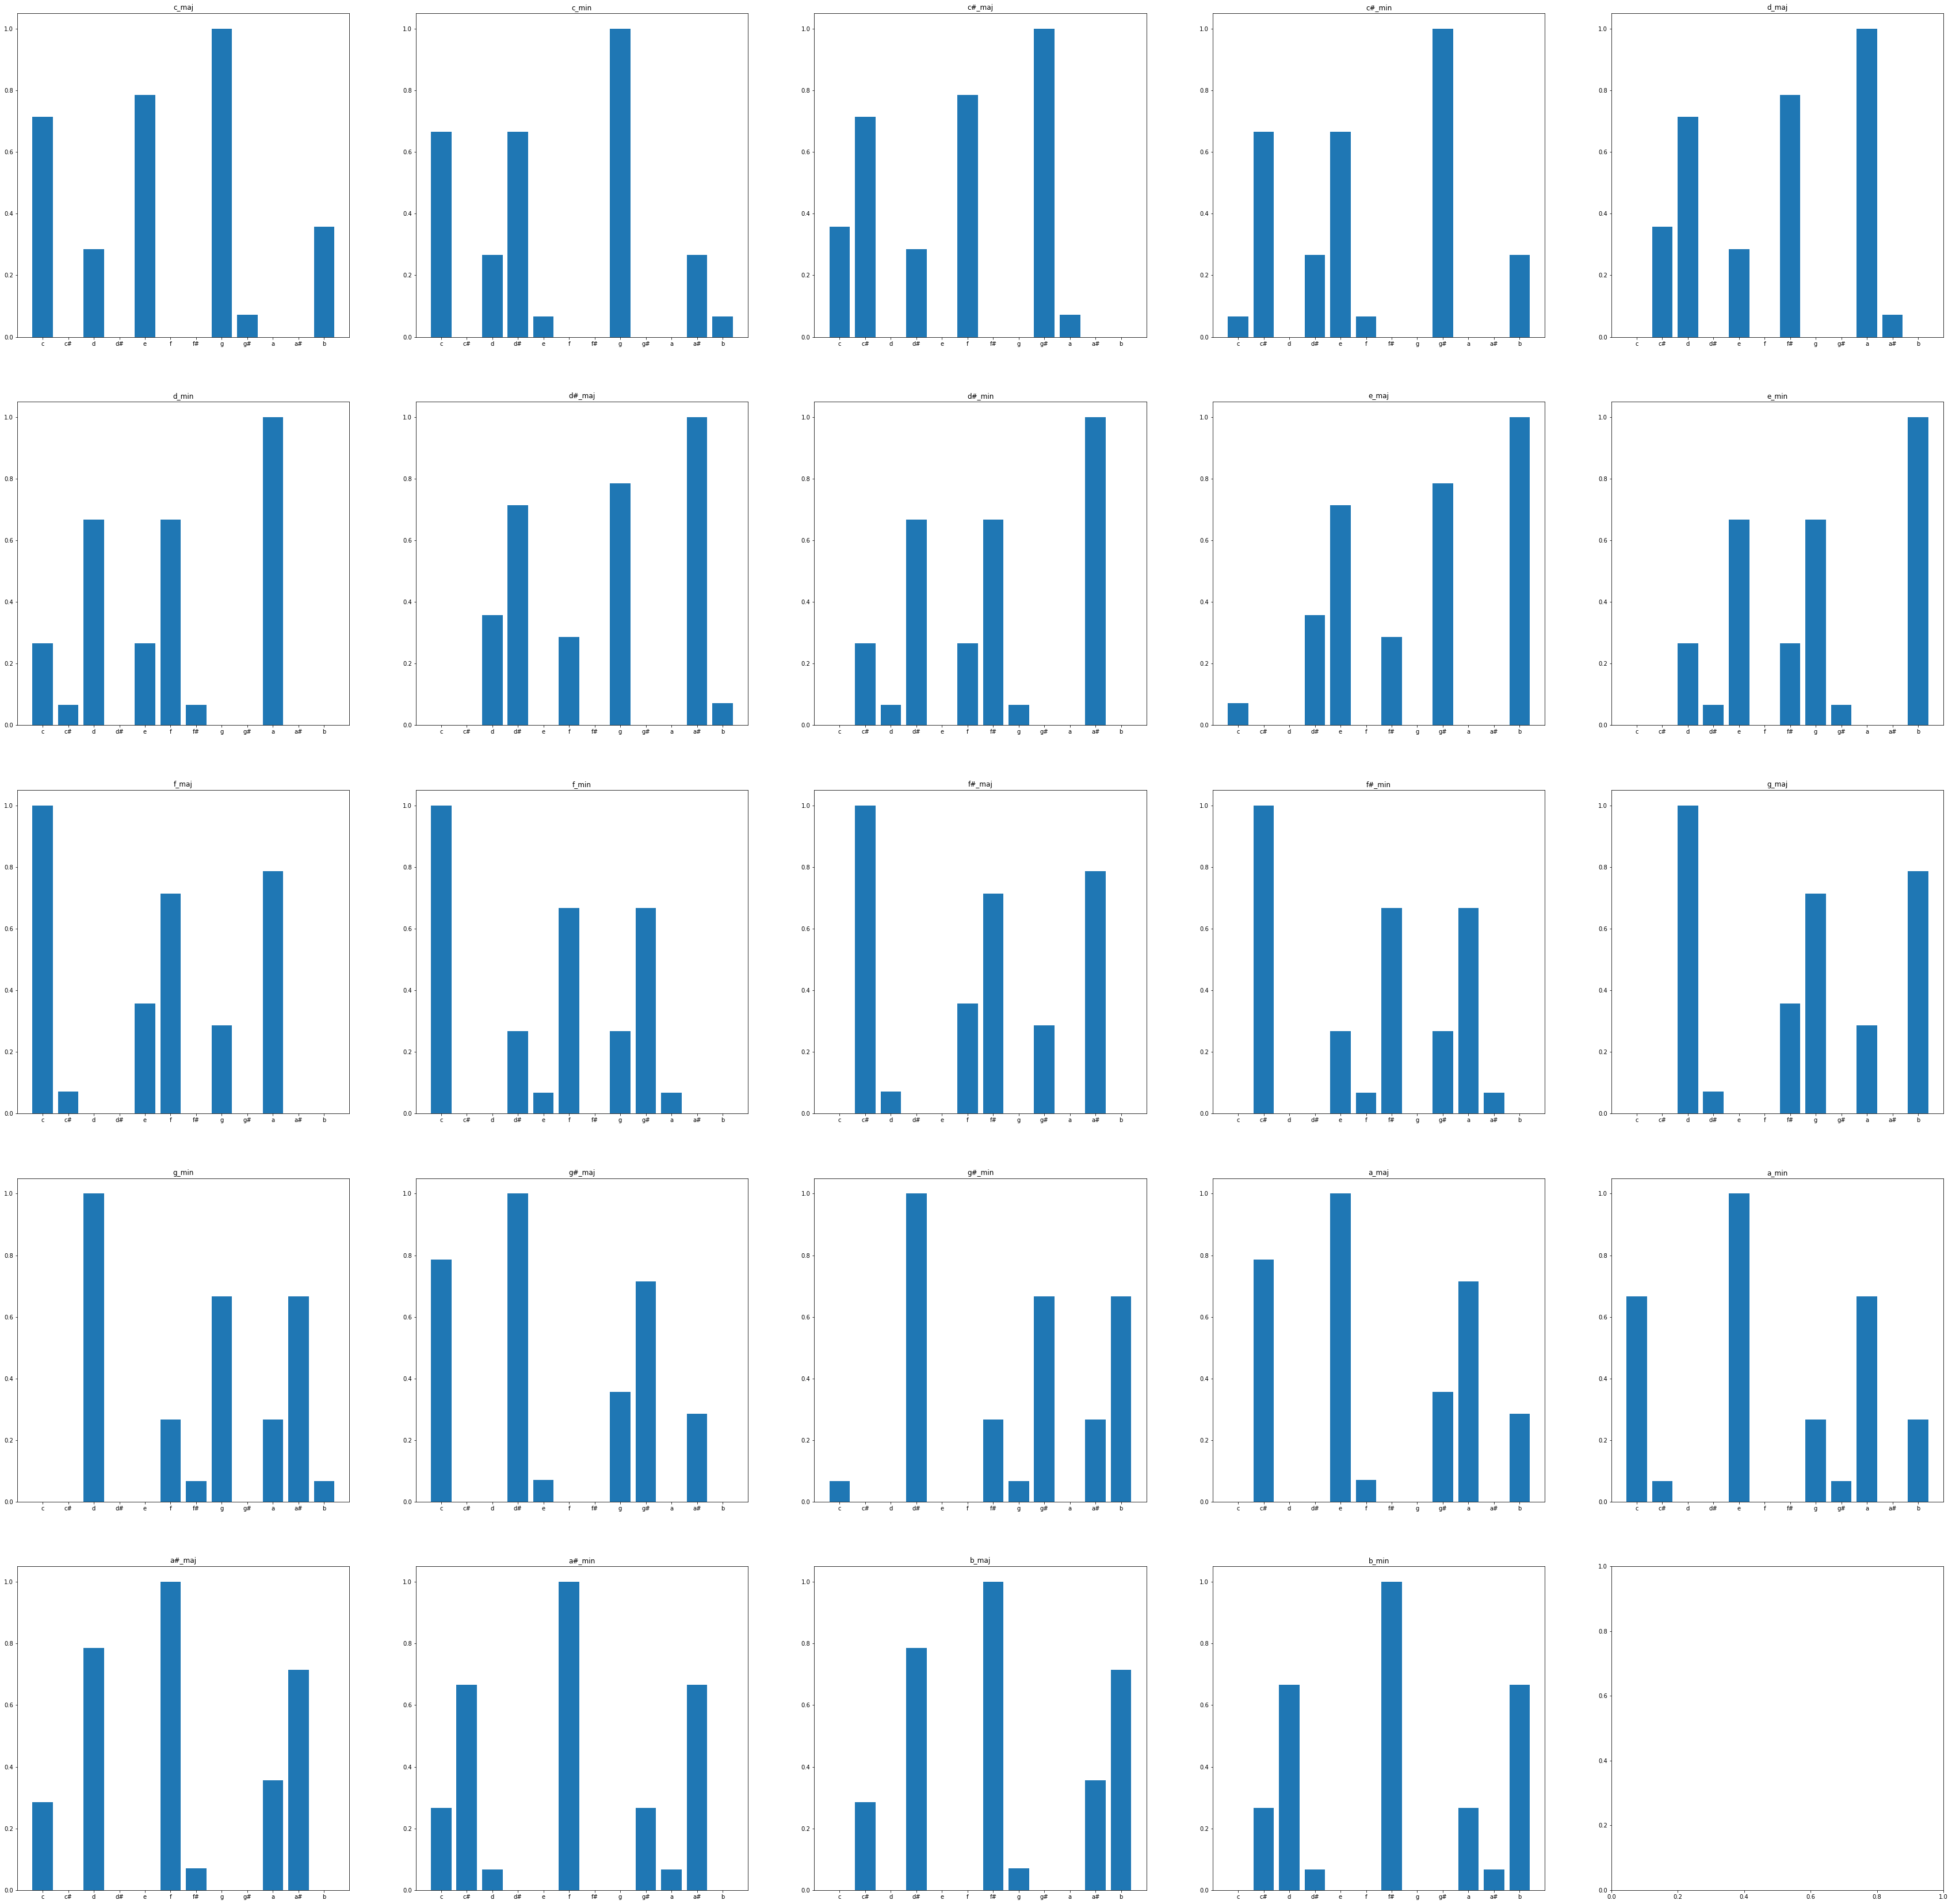

In [29]:
plt_chord_masks(5)

При процессинге композиции сначала она загружается с помощью librosa в формате временного ряда. Затем для композиции находятся точки, на которые выпадают "биения" или beats - по-простому это точки, в которых слушатель мог бы "притопывать ногой"; доказано, что именно в точках beats вероятнее всего смена аккорда. Далее для композиции находятся "вектора цветности", или PCP. Уже эти вектора сравниваются с подсчитанными масками с помощью косинусного расстояния и таким образом находится ближайший к звучащему аккорд.

In [31]:
path = "/Users/stacy-zlato/Documents/вкр/tlsp-eycte.wav"

ce = ChordsExtractor()

In [32]:
chords_tlsp, durations_tlsp = ce.process_composition(path)

In [33]:
print("Chords in The Last Shadow Puppets - Everything i've come to expect are: ", chords_tlsp)
print("Duration of first 10 chords:", durations_tlsp[:10])

Chords in The Last Shadow Puppets - Everything i've come to expect are:  ['f#_maj', 'f_maj', 'f_maj', 'c#_min', 'f_min', 'c#_maj', 'd_min', 'f_maj', 'f_maj', 'g_min', 'd_min', 'g_min', 'd_min', 'd_min', 'g_min', 'd_maj', 'd_min', 'a#_maj', 'a#_maj', 'd_min', 'd_min', 'f#_maj', 'c#_maj', 'c_maj', 'c#_maj', 'g_maj', 'f#_min', 'd_min', 'd_min', 'd_maj', 'g_min', 'g_min', 'd_min', 'a#_maj', 'a#_min', 'd#_maj', 'd#_maj', 'g#_maj', 'a#_min', 'a#_min', 'a#_min', 'g_min', 'g_min', 'g_min', 'd_min', 'g_min', 'd_min', 'g_min', 'd_min', 'a#_maj', 'a#_min', 'd#_min', 'g#_maj', 'c#_maj', 'c#_maj', 'a#_min', 'a#_min', 'f#_min', 'g_min', 'g_min', 'd_min', 'g_min', 'g_min', 'd_maj', 'd_min', 'a#_maj', 'a#_min', 'a_min', 'g#_maj', 'c#_min', 'c#_maj', 'f_min', 'f_maj', 'a_min', 'a_min', 'c_maj', 'f_maj', 'd_maj', 'a_min', 'd_maj', 'c_maj', 'd_min', 'd_min', 'c_maj', 'f_maj', 'd_maj', 'c_maj', 'b_min', 'f_maj', 'g_min', 'g_min', 'c_min', 'c_maj', 'e_maj', 'e_maj', 'd_min', 'e_maj', 'a_min', 'c_maj', 'c_m

## GuitarSet

In [ ]:
file_to_chord = guitar_set("/Users/stacy-zlato/Documents/вкр/PAGCD/audio_filtered/triads")

In [ ]:
def process_guitar_set_audio(path, chord):
    chords_extractor = ChordsExtractor()
    chords, durations = chords_extractor.process_composition(path)
    errors_cnt = len(np.where(np.array(chords) != chord))
    chords_cnt = len(chords)
    return chords_cnt, errors_cnt

total_cnt = 0
errors_cnt = 0

for path, chord in tqdm(file_to_chord.items()):
    total, errors = process_guitar_set_audio(path, chord)
    total_cnt += total
    errors_cnt += errors

accuracy = (total_cnt - errors_cnt) / total_cnt

print("Accuracy on guitar set chord is ", accuracy)

## Cross-composer dataset

In [ ]:
ce = ChordsExtractor()
chroma_df, chords_df = cross_composer_dataset(
    "/Users/stacy-zlato/Documents/вкр/cross-composer_chords-chordino/chords-chordino_01_bach.csv",
    "/Users/stacy-zlato/Documents/вкр/cross-composer_chroma-nnls/chroma-nnls_01_bach.csv")

assert len(chroma_df) == len(chords_df)

chords_matrix = []
expected_matrix = []

for i in trange(len(chroma_df)):
    expected = get_chords_to_compare(chords_df[i])

    beats, chroma, durations, total_duration = process_features_ccd(chroma_df[i], chords_df[i])

    chords, time = ce.process_composition_from_dataset(chroma, beats, durations, total_duration)
    chords_matrix.append(" ".join(chords))
    expected_matrix.append(" ".join(expected))

vectorizer = CountVectorizer(stop_words=None, token_pattern=r'\w#?_\w{3}7?', analyzer='word')
vectorizer.fit(chords_matrix + expected_matrix)

X = vectorizer.transform(chords_matrix)
Y = vectorizer.transform(expected_matrix)

In [ ]:
similarities = [1 - spatial.distance.cosine(X.toarray()[i], Y.toarray()[i]) for i in range(len(X.toarray()))]
print("Average cosine similarity between expected chords and resulting chords is ", np.mean(similarities))

# SIMPLICIAL
## Frequency Tonnetz

Для полученных аккордов строится фильтрованный симплициальный комплекс. Фильтрация происходит в зависимости от
частотности аккорда в композиции: в первый комплекс фильтрации попадают только самые частотные аккорды, далее с шагом
фильтрации в 0.005 рассматриваются все менее и менее частотные, пока не получим комплекс, содержащий в себе все аккорды.

Аналогично рассматриваются симплексы меньших размерностей: 0-d симплексы, отвечающие за PC, и 1-d симплексы, отвечающие
за интервалы. Их частотности вычисляются также относительно общего числа аккордов

In [ ]:
tonnetz = Tonnetz(tonnetz_type="frequency")
filtration = tonnetz.build_filtration(chords=chords_tlsp, durations=durations_tlsp)

In [ ]:
print("Simplices in filtration:", filtration.simplices())
print("Last index of filtration: ", filtration.getIndex())

Диаграммы устойчивости строятся на основе граничного оператора (= boundary operator, матрица границ).

К столбцам матрицы применяется алгоритм Гаусса (для приведения матрицы к ступенчатому виду).

Последовательно рассматриваются столбцы слева направо, low(x) – номер строки самого нижнего ненулевого элемента в столбце x

Если слева от текущего столбца x найдётся столбец y, что low(x) = low(y), то он, домноженный на соответствующий коэффициент, вычитается из x, тем самым low(x) уменьшается 

Это повторяется для текущего x, до тех пор, пока находится столбец y

Граничный оператор показывает, какие (k-1)-симплексы являются гранями k-симплексов. Это матрица, в которой колонки обозначают k-симплексы, строки - (k-1)-симплексы. Так, в матрице ниже 1 на пересечении 1 и 13 симплексов означает, что 1 входит в симплекс 13 как грань.

\begin{equation} 
\begin{bmatrix}
& | & 13 & 24 & 12 & 34 & 14 & 23 \\
\hline
1 & | & 1 & 0 & 1 & 0 & 1 & 0 \\
2 & | & 0 & 1 & 1 & 0 & 0 & 1 \\
3 & | & 1 & 0 & 0 & 1 & 0 & 1 \\
4 & | & 0 & 1 & 0 & 1 & 1 & 0
\end{bmatrix}
\end{equation}

In [ ]:
persistence_diagram = tonnetz.compute_persistence(k=2)
persistence_diagram

In [ ]:
tonnetz.plt_persistence()

In [ ]:
tonnetz.plot_persistence_image()

## Trajectories

Тоннец траектория - это граф в Тоннец-пространстве, показывающий последовательность аккордов во времени. Веса элементов в графе -
их длительность звучания; вершины, ребра и более сложные структуры задаются аналогично прошлому подходу.

Для каждого аккорда находятся координаты в заданном Тоннец-пространстве (например, Т(3,4,5)). Отсчет начинается от первого
"квадрата" плоскости, где (0,0) отвечает за высотный класс C. Сектор 3 х 4 с началом
в точке (0,0) задает все 12 высотных классов.

In [ ]:
tonnetz_traj = Tonnetz(tonnetz_type="trajectory")
traj_filtration = tonnetz_traj.build_filtration(chords=chords_tlsp, durations=durations_tlsp)

In [ ]:
tonnetz_traj.plt_trajectory()

In [ ]:
tonnetz_traj.compute_persistence(k=2)
tonnetz_traj.plt_persistence()

In [ ]:
print("Filtration from tonnetz traj with number of simplices: ", len(traj_filtration.simplices()))
print("Last index of filtration: ", traj_filtration.getIndex())

In [ ]:
tonnetz_traj.plot_persistence_image()

# EXPERIMENTS

## Topological representation

### GTZAN dataset

In [34]:
path = "/Users/stacy-zlato/Documents/вкр/GTZAN"

genres = list(filter(lambda x: x != '.DS_Store', os.listdir(path)))

In [35]:
def process_path(path, k=2):
    chords, durations = ce.process_composition(path)
    tonnetz_trajectory = Tonnetz(tonnetz_type="trajectory")
    tonnetz_trajectory.build_filtration(chords, durations)

    return tonnetz_trajectory.compute_persistence(k)
    # img = tonnetz_trajectory.compute_persistence_image()
    
    # return np.array([pixel for row in img for pixel in row])

In [46]:
data_lst = []
for genre in genres:
    genre_path = path + "/" + genre
    compositions = [[genre_path + "/" + x, genre] for x in os.listdir(genre_path)]
    data_lst.extend(compositions)
    
for composition in tqdm(data_lst):
    pers_diagram = process_path(composition[0], k=1)
    composition.append(pers_diagram)    

100%|██████████| 1000/1000 [32:40<00:00,  1.96s/it]


In [47]:
data_lst[:10]

[['/Users/stacy-zlato/Documents/вкр/GTZAN/pop/pop.00080.au',
  'pop',
  array([[ 75, 100],
         [100, 113],
         [ 48, 125],
         [ 85, 125],
         [101, 126],
         [137, 149],
         [137, 149],
         [138, 150],
         [137, 150],
         [148, 161],
         [137, 163],
         [165, 175],
         [113, 175],
         [176, 188],
         [163, 188],
         [175, 188],
         [175, 188],
         [ 62, 188],
         [178, 190]])],
 ['/Users/stacy-zlato/Documents/вкр/GTZAN/pop/pop.00022.au',
  'pop',
  array([[ 34,  56],
         [ 46,  68],
         [ 67,  78],
         [ 91, 102],
         [ 79, 112],
         [147, 158],
         [145, 178],
         [167, 178],
         [178, 189],
         [178, 189],
         [178, 189],
         [147, 190],
         [ 13, 190]])],
 ['/Users/stacy-zlato/Documents/вкр/GTZAN/pop/pop.00073.au',
  'pop',
  array([[ 91, 103],
         [ 95, 145],
         [136, 148],
         [152, 158],
         [130, 166],
       

In [48]:
data = [[x[0], x[1], x[2].tolist()] for x in data_lst]

In [49]:
with open("/Users/stacy-zlato/Documents/вкр/data_1.json", "w") as f:
    json.dump(data, f)

In [38]:
with open('/Users/stacy-zlato/Documents/вкр/data_1.json') as f:
    data = json.load(f)

In [50]:
data_filtered = list(filter(lambda x: x[2] != [], data))
persistence_diagrams = [x[2] for x in data_filtered]

In [51]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(genres)

LabelEncoder()

In [55]:
pimgr = PersistenceImager(pixel_size=1)
p_imgs = pimgr.fit_transform(persistence_diagrams, skew=True)

In [70]:
len(p_imgs)

1000

100%|██████████| 1000/1000 [1:30:14<00:00,  5.41s/it]


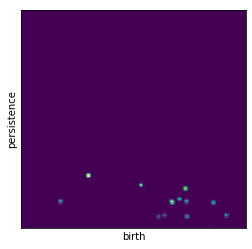

In [60]:
for i in trange(len(data_filtered)):
    id = "{}_{}.jpg".format(i, label_encoder.transform([data_filtered[i][1]])[0])
    pimgr.plot_image(p_imgs[i], out_file="/Users/stacy-zlato/Documents/вкр/gtzan_imgs/" + id)

In [71]:
X_data = [[pixel for row in img for pixel in row] for img in p_imgs]

In [72]:
Y_data = label_encoder.transform([x[1] for x in data_filtered])

In [73]:
len(X_data)

1000

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data,
                                                    stratify=Y_data,
                                                    test_size=0.3)

In [75]:
sparse_data = csr_matrix(X_train)

In [76]:
rf = RandomForestClassifier(n_estimators=100)

rf.fit(X_train, y_train)

RandomForestClassifier()

In [77]:
y_predicted_train = rf.predict(X_train)
score = accuracy_score(y_train, y_predicted_train)
score

0.9985714285714286

In [78]:
y_predicted_test = rf.predict(X_test)
score_test = accuracy_score(y_test, y_predicted_test)
score_test

0.16666666666666666

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]

max_depth.append(None)
# min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
# bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               # 'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
               # 'bootstrap': bootstrap}

In [ ]:
clf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=10,
                               random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
predicted_train =  clf.predict(X_train)
score = accuracy_score(y_train, predicted_train)

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)


In [6]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [4]:
import re
import shutil

base_path = "/Users/stacy-zlato/Documents/вкр/gtzan_imgs"

images_files = list(map(lambda x: base_path + "/" + x, filter(lambda x: x != '.DS_Store', os.listdir(base_path))))

In [112]:
name_mathcer = re.search(r"(.*?\/)(\d+_(\d).jpg)$", images_files[0])
name_mathcer.groups()

('/Users/stacy-zlato/Documents/вкр/gtzan_imgs/', '962_5.jpg', '5')

In [113]:
regex = r".*?\d+_(\d).jpg$"

y_data = []

for img_file in images_files:
    matcher = re.search(regex, img_file)
    if matcher:
        y_data.append(int(matcher.group(1)))
    else:
        print(img_file)

x_train, x_test, y_train, y_test = train_test_split(images_files, y_data)

In [114]:
def move_img_to_folder(img_path, folder):
    if not os.path.isfile(img_path):
        return
    name_mathcer = re.search(r"(.*?\/)(\d+_(\d).jpg)$", img_path)
    if name_mathcer:
        dir = name_mathcer.group(1) + folder + "/"
        if not os.path.isdir(dir):
            os.mkdir(dir)
        dir += label_encoder.inverse_transform([int(name_mathcer.group(3))])[0] + "/"
        if not os.path.isdir(dir):
            os.mkdir(dir)
        new_path = dir + \
                   name_mathcer.group(2)
        shutil.move(img_path, new_path)
        return new_path
    print(img_path)

for i in trange(len(x_train)):
    new_path = move_img_to_folder(x_train[i], "train")
    x_train[i] = new_path

for i in trange(len(x_test)):
    new_path = move_img_to_folder(x_test[i], "test")
    x_test[i] = new_path

100%|██████████| 250/250 [00:00<00:00, 1280.55it/s]


In [14]:
dataset = ImageFolder(base_path + "/binary/train/", transform = transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))

test_dataset = ImageFolder(base_path + "/binary/test/", transform=transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))

Label : classical


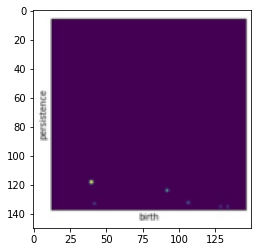

In [15]:
import matplotlib.pyplot as plt
def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(*dataset[10])

In [16]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 128
val_size = 100
train_size = len(dataset) - val_size

train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

#output
#Length of Train Data : 12034
#Length of Validation Data : 2000

#load the train and validation into batches.
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)

Length of Train Data : 40
Length of Validation Data : 100


In [17]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [18]:
class CompositionsClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(82944,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,2)
        )

    def forward(self, xb):
        return self.network(xb)

In [19]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):

    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in trange(epochs):

        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [20]:
model = CompositionsClassification()
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  3%|▎         | 1/30 [00:39<19:06, 39.53s/it]

Epoch [0], train_loss: 0.6945, val_loss: 1.2566, val_acc: 0.4900



  7%|▋         | 2/30 [01:17<17:58, 38.54s/it]

Epoch [1], train_loss: 1.0066, val_loss: 0.6940, val_acc: 0.5100



 10%|█         | 3/30 [01:53<16:55, 37.62s/it]

Epoch [2], train_loss: 0.7087, val_loss: 0.6930, val_acc: 0.5100



 13%|█▎        | 4/30 [02:29<15:53, 36.67s/it]

Epoch [3], train_loss: 0.6965, val_loss: 0.6939, val_acc: 0.4900



 17%|█▋        | 5/30 [03:04<15:09, 36.38s/it]

Epoch [4], train_loss: 0.6886, val_loss: 0.6949, val_acc: 0.4900



 20%|██        | 6/30 [03:40<14:27, 36.16s/it]

Epoch [5], train_loss: 0.6855, val_loss: 0.6990, val_acc: 0.4900



 23%|██▎       | 7/30 [04:16<13:48, 36.03s/it]

Epoch [6], train_loss: 0.6791, val_loss: 0.7215, val_acc: 0.4900



 27%|██▋       | 8/30 [04:50<12:57, 35.36s/it]

Epoch [7], train_loss: 0.6731, val_loss: 0.7489, val_acc: 0.4900



 30%|███       | 9/30 [05:25<12:21, 35.31s/it]

Epoch [8], train_loss: 0.6791, val_loss: 0.7236, val_acc: 0.4900



 30%|███       | 9/30 [05:45<13:25, 38.36s/it]


KeyboardInterrupt: 

In [ ]:
binary_data = list(filter(lambda x: x[1] == 'rock' or x[1] == 'pop', data_filtered))

In [ ]:
binary_pd = [x[2] for x in binary_data]

In [ ]:
pimgr = PersistenceImager(pixel_size=1)
p_imgs = pimgr.fit_transform(binary_pd, skew=True)

In [ ]:
binary_y = [x[1] for x in binary_data]

p_imgs_flatten = np.array([p_img.flatten() for p_img in p_imgs])

le = preprocessing.LabelEncoder()
binary_y = le.fit_transform(binary_y)

X_train, X_test, y_train, y_test = train_test_split(p_imgs_flatten, binary_y,
                                                    stratify=binary_y,
                                                    test_size=0.3)



In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf = clf.fit(X_train, y_train)

In [ ]:
predicted_train =  clf.predict(X_train)
score = accuracy_score(y_train, predicted_train)
score

In [ ]:
predicted_test =  clf.predict(X_test)
score = accuracy_score(y_test, predicted_test)
score

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]

# criterion=['gini', 'entropy']
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
               # 'criterion': criterion}

In [ ]:
clf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

In [ ]:
rf_random.best_params_

In [ ]:
predicted_test =  rf_random.best_estimator_.predict(X_test)
score = accuracy_score(y_test, predicted_test)

score

In [ ]:
predicted_train =  rf_random.best_estimator_.predict(X_train)
score = accuracy_score(y_train, predicted_train)

score